# Imports

In [96]:
import torchvision
import torch
from torchvision import transforms
import timm
import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from torchvision.models.resnet import resnet34
import numpy as np 
import random 
import os 
import matplotlib.pyplot as plt

# Utils

In [97]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [98]:
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [99]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
test_transform = transforms.Compose([
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [100]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

# Dataset

In [101]:
seed_everything(49)
ds_train = torchvision.datasets.CIFAR10('data', download=True, transform = transforms.ToTensor())
# ds_train = torch.utils.data.Subset(ds_train, list(range(len(ds_train) // int(1/0.2))))
# ds_train = torch.utils.data.Subset(ds_train, [0, 1])
ds_test = torchvision.datasets.CIFAR10('data', train=False, download=True, transform = transforms.ToTensor())
#ds_test = test_transforms(ds_test)
class_dict = {
    0: 'airplane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Files already downloaded and verified
Files already downloaded and verified


# Model

In [102]:
class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet34().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        # projection head
        self.g = nn.Sequential(nn.Linear(512, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        q = self.g[0](feature)
        
        return 0, F.normalize(q, dim=-1), F.normalize(out, dim=-1)

# Misclassifications

In [103]:
def get_misclassified(model, dl_test, dl_train, k=200):
    incorrect_samples = []
    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        train_preds_q = []
        labels = []
        for batch in tqdm(dl_train):
            X,y = batch
            X = move_to(X, DEVICE)
            y = move_to(y, DEVICE)
            
            X = test_transform(X)
            
            output_x, output_q , output_z = model(X)
            
            train_preds_q.append(output_q)
            
            labels.append(y)
        
        train_preds_q = torch.cat(train_preds_q, dim=0)
        labels = torch.cat(labels, dim=0)
        
        for batch in tqdm(dl_test):
            X, y = batch
            X = move_to(X, DEVICE)
            y = move_to(y, DEVICE)
            
            X = test_transform(X)
            
            output_x, output_q , output_z = model(X)

            distances_q = train_preds_q @ torch.transpose(output_q, 0, 1)

            distance_q, sim_indices_q = distances_q.topk(k=k, dim=0)
            
            sim_labels_q = torch.gather(labels.expand(sim_indices_q.shape[0], -1), dim=-1, index=sim_indices_q)
            
            # [batch_size]
            max_labels_q, _ = torch.mode(sim_labels_q, dim=0)
            
            incorrect_mask = y != max_labels_q
            incorrect = X[incorrect_mask]
            true_labels.append(y[incorrect_mask])
            predicted_labels.append(max_labels_q[incorrect_mask])
            
            incorrect_samples.append(incorrect)
    incorrect_samples = torch.cat(incorrect_samples, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    predicted_labels = torch.cat(predicted_labels, dim=0)
            
    return incorrect_samples, true_labels, predicted_labels

In [104]:
def misclassified_stats(samples, true_labels, predicted_labels):
    unique_true_labels = torch.unique(true_labels)
    unique_predicted_labels = torch.unique(predicted_labels)
    
    for i in range(len(unique_true_labels)):
        label = unique_true_labels[i]
        print(f"True label: {class_dict[label.item()]}")
        mask = true_labels == label
        predictions = predicted_labels[mask]
        unique, counts = torch.unique(predictions, return_counts=True)
        for k in range(len(unique)):
            print(f"    {counts[k]} predictions of {class_dict[unique[k].item()]}")
        print(len(predictions))

In [105]:
import cv2
def plot_misclassified(samples, true_labels, predicted_labels, n_images=3):
    resize = torchvision.transforms.Resize((128,128))
    unique_true_labels = torch.unique(true_labels)
    n_unique_labels = len(unique_true_labels)
    fig, axes = plt.subplots(n_unique_labels, n_images, figsize=(5, 16))
    for i in range(n_unique_labels):
        label = unique_true_labels[i]
        mask = true_labels == label
        current_samples = samples[mask]
        current_predictions = predicted_labels[mask]
        n_incorrect = len(current_samples)
        for k in range(n_images):
            if k < n_incorrect:
                ax = axes[i, k]
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                
                sample = current_samples[k]
                prediction = current_predictions[k]
                sample = resize(sample)
                image = torch.permute(sample, (1,2,0)).cpu().numpy()
                image_mask = np.zeros((128,128))
                norm_image = cv2.normalize(image, image_mask, 0, 1, cv2.NORM_MINMAX)
                image = np.clip(norm_image, 0, 1)
                if k == 0:
                    ax.set_ylabel(f"{class_dict[label.item()]}", color='red',fontsize=18)
                ax.set_title(f"{class_dict[prediction.item()]}", fontsize=16)
                ax.imshow(image)
    fig.tight_layout()

In [106]:
model = Model()
model.cuda()
model.load_state_dict(torch.load("best_model_resnet34.pt"))

batch_size_train = 20
batch_size_test = 20
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True, num_workers=2, pin_memory=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size_test, shuffle=True, num_workers=2, pin_memory=True)

incorrect_samples, true_labels, predicted_labels = get_misclassified(model, dl_test, dl_train)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

True label: airplane
    12 predictions of car
    41 predictions of bird
    15 predictions of cat
    11 predictions of deer
    12 predictions of dog
    17 predictions of frog
    11 predictions of horse
    83 predictions of ship
    28 predictions of truck
230
True label: car
    18 predictions of airplane
    1 predictions of bird
    6 predictions of cat
    1 predictions of deer
    1 predictions of dog
    1 predictions of frog
    1 predictions of horse
    7 predictions of ship
    80 predictions of truck
116
True label: bird
    107 predictions of airplane
    61 predictions of cat
    179 predictions of deer
    76 predictions of dog
    104 predictions of frog
    38 predictions of horse
    4 predictions of ship
    8 predictions of truck
577
True label: cat
    26 predictions of airplane
    8 predictions of car
    55 predictions of bird
    56 predictions of deer
    230 predictions of dog
    95 predictions of frog
    41 predictions of horse
    7 predictions of sh

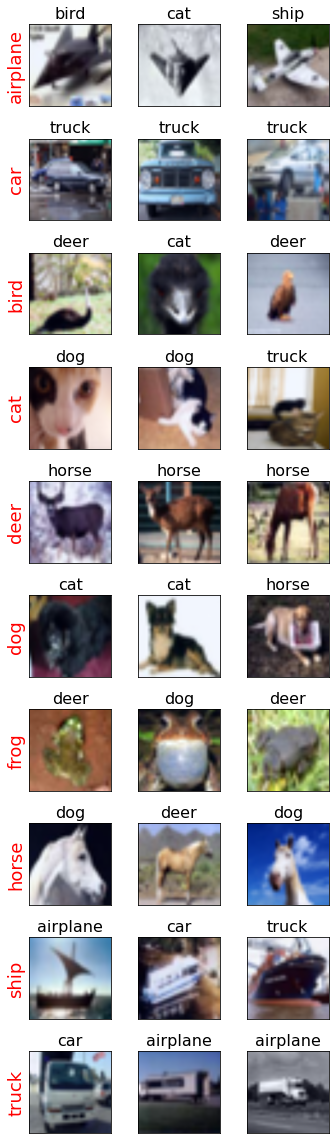

In [107]:
misclassified_stats(incorrect_samples, true_labels, predicted_labels)
plot_misclassified(incorrect_samples, true_labels, predicted_labels, n_images=3)

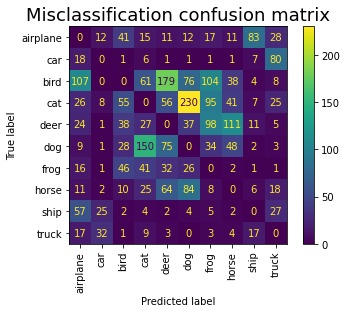

In [108]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), labels=[i for i in range(10)])
disp = ConfusionMatrixDisplay(cm, display_labels=[class_dict[i] for i in range(10)])
disp.plot(xticks_rotation='vertical')
plt.title("Misclassification confusion matrix", fontsize=18)
plt.show()